In [1]:
import os
import pdb
import pickle
import argparse
import time

import warnings
warnings.filterwarnings("ignore")

# Numpy & Scipy imports
import numpy as np
import scipy
import scipy.misc
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import display

# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim

# Local imports
import utils
from data_loader import get_mnist_data
from models import Generator, Discriminator, Recognition, SharedPartDQ
from infogan import *

In [2]:
path = 'mnist_58_epochs/'
opts = pickle.load( open( path + "/model/opts.pkl", "rb" ) )
opts.checkpoint_dir = path
opts.directory = path
opts.display_debug = False
opts.interp_size = 10
opts

Namespace(batch_size=16, beta1=0.5, beta2=0.99, cat_dim_size=10, cat_dims_count=1, checkpoint_dir='mnist_58_epochs/', checkpoint_every=1000, colab=True, cont_dims_count=2, dataset='MNIST', directory='mnist_58_epochs/', display_debug=False, interp_size=10, load=None, log_step=10000, lrD=0.0002, lrG=0.001, noise_size=74, num_epochs=100, num_workers=0, sample_every=1000)

In [3]:
G, D, Q, DQ = load_checkpoint(opts)

None selected, thus we assume we load from checkpoint_dir.


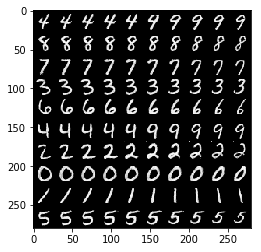

In [4]:
noise = get_fixed_noise(opts)
generated_images = G(noise)
generated_images = utils.to_data(generated_images)
grid = create_image_grid(generated_images, ncols=opts.interp_size)
plt.imshow(grid, cmap='gray')

In [5]:
def f(seed, cat, c1, c2):
    c1 /= 1000
    c2 /= 1000
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    fixed_noise = utils.to_var(torch.rand(100, opts.noise_size) * 2 - 1)
    onehot_categories = np.eye(10)

    noise = fixed_noise
    noise[0,:10] = torch.tensor(onehot_categories[cat])
    noise[0,10] = c1
    noise[0,11] = c2
    
    res = G(noise)
    plt.imshow(res[0][0].cpu().detach().numpy(), cmap='gray')
    
d_cont = 100

# Note that the sliders need to be of type int to be able to use the play animation
# Therefore the values are divided by a thousand to represent the actual latent variable
seed = widgets.IntSlider(min=0,max=100,step=1,value=20, continuous_update=False)
cat = widgets.IntSlider(min=-0,max=9,step=1,value=3, continuous_update=True)
c1 = widgets.IntSlider(min=-3000,max=3000,step=d_cont,value=0, continuous_update=False)
c2 = widgets.IntSlider(min=-3000,max=3000,step=d_cont,value=0, continuous_update=False)

play_cat = widgets.Play(
    interval=1000,
    value=3,
    min=0,
    max=9,
    step=1,
    description="Press play",
    disabled=False
)

play_c1 = widgets.Play(
    interval=250,
    value=0,
    min=-3000,
    max=3000,
    step=d_cont,
    description="Press play",
    disabled=False
)

play_c2 = widgets.Play(
    interval=250,
    value=0,
    min=-3000,
    max=3000,
    step=d_cont,
    description="Press play",
    disabled=False
)

interactive_plot = interactive(f, seed=seed, cat=cat, c1=c1, c2=c2)

output = interactive_plot.children[-1]
output.layout.height = '250px'

# Interactive slider below:
Note that the values for c1 and c2 need to be divided by a thousand and that the working range is between -2 and 2, but it is possible to see what happens in the range of -3 and 3.

In [6]:
interactive_plot

interactive(children=(IntSlider(value=20, continuous_update=False, description='seed'), IntSlider(value=3, des…

In [7]:
widgets.jslink((play_cat, 'value'), (cat, 'value'))
widgets.jslink((play_c1, 'value'), (c1, 'value'))
widgets.jslink((play_c2, 'value'), (c2, 'value'))
widgets.VBox([widgets.HBox([play_cat, cat]), widgets.HBox([play_c1, c1]), widgets.HBox([play_c2, c2])])

# Use the controls above for a smooth animation across (multiple) variables